Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Wrangle ML datasets 
- Explore tabular data for supervised machine learning
- Join relational data for supervised machine learning

# Explore tabular data for superviesd machine learning 🍌

Wrangling your dataset is often the most challenging and time-consuming part of the modeling process.

In today's lesson, we’ll work with a dataset of [3 Million Instacart Orders, Open Sourced](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2)!

Let’s get set up:

In [1]:
# Download data
import requests

def download(url):
    filename = url.split('/')[-1]
    print(f'Downloading {url}')
    r = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(r.content)
    print(f'Downloaded {filename}')

download('https://s3.amazonaws.com/instacart-datasets/instacart_online_grocery_shopping_2017_05_01.tar.gz')

Downloaded instacart_online_grocery_shopping_2017_05_01.tar.gz


In [0]:
# Uncompress data
import tarfile
tarfile.open('instacart_online_grocery_shopping_2017_05_01.tar.gz').extractall()

In [3]:
# Change directory to where the data was uncompressed
%cd instacart_2017_05_01

/content/instacart_2017_05_01


In [4]:
# Print the csv filenames
from glob import glob
for filename in glob('*.csv'):
    print(filename)

products.csv
order_products__prior.csv
departments.csv
orders.csv
aisles.csv
order_products__train.csv


In [19]:
# For each csv file, look at its shape & head
import pandas as pd

def preview():
  for filename in glob('*.csv'):
    df = pd.read_csv(filename)
    print(f'{filename} shape: {df.shape}')


preview()

products.csv shape: (49688, 4)
order_products__prior.csv shape: (32434489, 4)
departments.csv shape: (21, 2)
orders.csv shape: (3421083, 7)
aisles.csv shape: (134, 2)
order_products__train.csv shape: (1384617, 4)


### The original task was complex ...

[The Kaggle competition said,](https://www.kaggle.com/c/instacart-market-basket-analysis/data):

> The dataset for this competition is a relational set of files describing customers' orders over time. The goal of the competition is to predict which products will be in a user's next order.

> orders.csv: This file tells to which set (prior, train, test) an order belongs. You are predicting reordered items only for the test set orders.

Each row in the submission is an order_id from the test set, followed by product_id(s) predicted to be reordered.

> sample_submission.csv: 
```
order_id,products
17,39276 29259
34,39276 29259
137,39276 29259
182,39276 29259
257,39276 29259
```

### ... but we can simplify!

Simplify the question, from "Which products will be reordered?" (Multi-class, [multi-label](https://en.wikipedia.org/wiki/Multi-label_classification) classification) to **"Will customers reorder this one product?"** (Binary classification)

Which product? How about **the most frequently ordered product?**

### Questions:

- What is the most frequently ordered product?
- How often is this product included in a customer's next order?
- Which customers have ordered this product before?
- How can we get a subset of data, just for these customers?
- What features can we engineer? We want to predict, will these customers reorder this product on their next order?

## Follow Along

### What was the most frequently ordered product?

In [20]:
order_products__train = pd.read_csv('order_products__train.csv')
order_products__train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [21]:
order_products__train['product_id'].value_counts()

24852    18726
13176    15480
21137    10894
21903     9784
47626     8135
         ...  
44256        1
2764         1
4815         1
43736        1
46835        1
Name: product_id, Length: 39123, dtype: int64

In [24]:
# how many times each product appeared in different orders
order_products__train.groupby('product_id')['order_id'].count().sort_values(ascending=False)

product_id
24852    18726
13176    15480
21137    10894
21903     9784
47626     8135
         ...  
29560        1
8001         1
29566        1
8005         1
24836        1
Name: order_id, Length: 39123, dtype: int64

In [25]:
products = pd.read_csv('products.csv')
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [33]:
train = pd.merge(order_products__train, products, on='product_id', how='inner')
train.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,1,49302,1,1,Bulgarian Yogurt,120,16
1,816049,49302,7,1,Bulgarian Yogurt,120,16
2,1242203,49302,1,1,Bulgarian Yogurt,120,16
3,1383349,49302,11,1,Bulgarian Yogurt,120,16
4,1787378,49302,8,0,Bulgarian Yogurt,120,16


In [34]:
train['product_name'].value_counts()

Banana                                           18726
Bag of Organic Bananas                           15480
Organic Strawberries                             10894
Organic Baby Spinach                              9784
Large Lemon                                       8135
                                                 ...  
Super Premium Chocolate Ice Cream                    1
For Men 3 In 1 Nourishing Lotion Sea Minerals        1
Garlic Naan Bread                                    1
Sweet Potato Ribbons                                 1
Calendula Body Lotion                                1
Name: product_name, Length: 39123, dtype: int64

### How often are bananas included in a customer's next order?

There are [three sets of data](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b):

> "prior": orders prior to that users most recent order (3.2m orders)  
"train": training data supplied to participants (131k orders)  
"test": test data reserved for machine learning competitions (75k orders)

Customers' next orders are in the "train" and "test" sets. (The "prior" set has the orders prior to the most recent orders.)

We can't use the "test" set here, because we don't have its labels (only Kaggle & Instacart have them), so we don't know what products were bought in the "test" set orders.

So, we'll use the "train" set. It currently has one row per product_id and multiple rows per order_id.

But we don't want that. Instead we want one row per order_id, with a binary column: "Did the order include bananas?"

Let's wrangle!

In [35]:
train['bananas'] = train['product_name'] == 'Banana'
train.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,bananas
0,1,49302,1,1,Bulgarian Yogurt,120,16,False
1,816049,49302,7,1,Bulgarian Yogurt,120,16,False
2,1242203,49302,1,1,Bulgarian Yogurt,120,16,False
3,1383349,49302,11,1,Bulgarian Yogurt,120,16,False
4,1787378,49302,8,0,Bulgarian Yogurt,120,16,False


In [36]:
train['bananas'].value_counts(normalize=True)

False    0.986476
True     0.013524
Name: bananas, dtype: float64

In [38]:
train.shape

(1384617, 8)

In [37]:
train_wrangled = train.groupby('order_id')['bananas'].any().reset_index()
train_wrangled.head()

,order_id,bananas
0,1,False
1,36,False
2,38,False
3,96,False
4,98,False


In [42]:
train_wrangled.shape

(223586720456, (131209, 2))

In [0]:
train['bananas'] = train_wrangled['bananas'] == True

In [45]:
train['bananas'].value_counts(normalize=True)

False    0.857281
True     0.142719
Name: bananas, dtype: float64

# Join relational data for supervised machine learning

## Overview
Often, you’ll need to join data from multiple relational tables before you’re ready to fit your models.

### Which customers have ordered this product before?

- Customers are identified by `user_id`
- Products are identified by `product_id`

Do we have a table with both these id's? (If not, how can we combine this information?)

In [46]:
train[train['bananas']==True]

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,bananas
8,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,True
12,128666,11109,12,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,True
18,245323,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,True
24,347470,11109,5,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,True
29,485991,11109,16,0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,True
...,...,...,...,...,...,...,...,...
131140,267937,24852,2,1,Banana,24,4,True
131141,268029,24852,3,1,Banana,24,4,True
131145,268418,24852,4,1,Banana,24,4,True
131163,271143,24852,8,0,Banana,24,4,True


In [0]:
banana_order_id = train[train['bananas']==True]['order_id']

In [48]:
orders = pd.read_csv('orders.csv')
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [49]:
orders['order_id'].isin(banana_order_id)

0          False
1          False
2          False
3          False
4          False
           ...  
3421078    False
3421079    False
3421080    False
3421081    False
3421082    False
Name: order_id, Length: 3421083, dtype: bool

In [63]:
banana_orders = orders[orders['order_id'].isin(banana_order_id)]
banana_orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
78,880375,8,train,4,1,14,10.0
395,2614670,27,train,82,5,14,4.0
669,2924697,48,train,11,5,18,14.0
746,1750084,50,train,68,3,9,7.0
988,2989905,63,train,40,6,8,13.0
...,...,...,...,...,...,...,...
3420686,2108733,206190,train,9,5,14,30.0
3420692,2530125,206191,train,6,0,9,30.0
3420862,943915,206200,train,24,6,19,6.0
3420924,2371631,206203,train,6,4,19,30.0


In [69]:
banana_user_id = banana_orders['user_id'].unique()
banana_user_id

array([     8,     27,     48, ..., 206200, 206203, 206205])

In [70]:
banana_user_id.shape

(16398,)

## Follow Along

### How can we get a subset of data, just for these customers?

We want *all* the orders from customers who have *ever* bought bananas.

(And *none* of the orders from customers who have *never* bought bananas.)

In [71]:
orders.shape

(3421083, 7)

In [75]:
orders_subset = orders[orders['user_id'].isin(banana_user_id)]
orders_subset.shape

(305598, 7)

In [76]:
orders_subset.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
75,600894,8,prior,1,6,0,NaN
76,2979257,8,prior,2,1,8,30.0
77,2570360,8,prior,3,5,0,30.0
78,880375,8,train,4,1,14,10.0
314,361493,27,prior,1,3,9,NaN


### What features can we engineer? We want to predict, will these customers reorder bananas on their next order?

- Days since last banana order
- Time of day
- Have they ordered bananas before? If so, how many times? (if not = 0)
- Frequency of ordering fruits and veg 
- Is the majority of items in the order fruit?
- Size of an order

In [77]:
USER_ID = 8
orders_subset[orders_subset['user_id']==USER_ID]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
75,600894,8,prior,1,6,0,NaN
76,2979257,8,prior,2,1,8,30.0
77,2570360,8,prior,3,5,0,30.0
78,880375,8,train,4,1,14,10.0


In [79]:
merged_df = orders.merge(order_products__train).merge(products)
merged_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,1187899,1,train,11,4,8,14.0,196,1,1,Soda,77,7
1,2757217,67,train,25,0,11,5.0,196,1,1,Soda,77,7
2,632715,676,train,12,0,13,26.0,196,2,1,Soda,77,7
3,1167274,760,train,5,4,10,8.0,196,2,1,Soda,77,7
4,3347074,804,train,16,3,21,5.0,196,4,0,Soda,77,7


In [80]:
merged_df.shape

(1384617, 13)

In [81]:
merged_df_bananas = merged_df[merged_df['product_name']=='Banana']
merged_df_bananas

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
15942,1492625,2,train,15,1,11,30.0,24852,8,1,Banana,24,4
15943,698604,34,train,6,4,13,30.0,24852,2,0,Banana,24,4
15944,1864787,43,train,12,5,11,26.0,24852,1,1,Banana,24,4
15945,1947848,46,train,20,4,20,11.0,24852,1,1,Banana,24,4
15946,13318,56,train,13,1,9,6.0,24852,1,1,Banana,24,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34663,681092,206181,train,15,1,13,30.0,24852,1,1,Banana,24,4
34664,2530125,206191,train,6,0,9,30.0,24852,12,1,Banana,24,4
34665,3383615,206196,train,5,0,15,30.0,24852,2,1,Banana,24,4
34666,1716008,206205,train,4,1,16,10.0,24852,5,0,Banana,24,4


In [82]:
merged_df_bananas['user_id']

15942         2
15943        34
15944        43
15945        46
15946        56
          ...  
34663    206181
34664    206191
34665    206196
34666    206205
34667    206209
Name: user_id, Length: 18726, dtype: int64

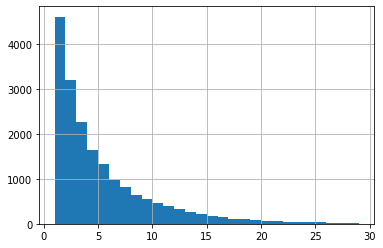

In [85]:
# at what point do people add bananas to their shopping cart?

merged_df_bananas['add_to_cart_order'].hist(bins=range(1,30));

## Challenge

**Continue to clean and explore your data.** Can you **engineer features** to help predict your target? For the evaluation metric you chose, what score would you get just by guessing? Can you **make a fast, first model** that beats guessing?

We recommend that you use your portfolio project dataset for all assignments this sprint. But if you aren't ready yet, or you want more practice, then use the New York City property sales dataset today. Follow the instructions in the assignment notebook. [Here's a video walkthrough](https://youtu.be/pPWFw8UtBVg?t=584) you can refer to if you get stuck or want hints!